<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gap-behaviour" data-toc-modified-id="Gap-behaviour-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gap behaviour</a></span></li><li><span><a href="#Adiabatic-evolution-experiments" data-toc-modified-id="Adiabatic-evolution-experiments-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Adiabatic evolution experiments</a></span></li><li><span><a href="#Failed-attempts-at-OC-with-qutip" data-toc-modified-id="Failed-attempts-at-OC-with-qutip-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Failed attempts at OC with qutip</a></span></li><li><span><a href="#Manually-implemented-CRAB-OC" data-toc-modified-id="Manually-implemented-CRAB-OC-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Manually implemented CRAB OC</a></span><ul class="toc-item"><li><span><a href="#CRAB-optimisation-tests" data-toc-modified-id="CRAB-optimisation-tests-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>CRAB optimisation tests</a></span></li><li><span><a href="#Optimizations-with-different-$\Omega$" data-toc-modified-id="Optimizations-with-different-$\Omega$-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Optimizations with different $\Omega$</a></span></li></ul></li></ul></div>

In [1]:
import datetime
import logging
import os
import pickle
import sys
import time
import functools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()
import progressbar
import qutip
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.logging_utils
import scipy
import seaborn as sns

if './src/' not in sys.path:
    sys.path.append('./src/')
import rabi_model
import lmg_model
import optimization
import protocol_ansatz as protocols
from utils import ground_state

sns.set()

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Gap behaviour

Behaviour of spectrum near the critical point

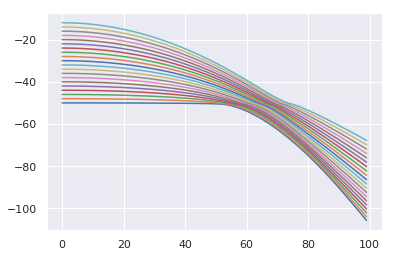

In [253]:
N = 100
Omega = 100
omega_0 = 1
lambdas = np.linspace(0, 10, 100)
num_eigenvalues = 20
spectrum = np.zeros(shape=(len(lambdas), num_eigenvalues))
for idx, lambda_ in enumerate(lambdas):
    eigvals = rabi_model.QRM_full(N=N, Omega=Omega, omega_0=omega_0, lambda_=lambda_).eigenstates(
        eigvals=num_eigenvalues)[0]
    spectrum[idx] = eigvals
plt.figure()
plt.plot(spectrum);

Plotting the lowest eigenvalues of the interacting Rabi model against the interaction parameter reveals the change in behavior at the critical point. In particular, it is clearly seen how the ground state becomes degenerate at the critical point: the first two eigenvalues merge at around the critical point, as shown in the plots below:

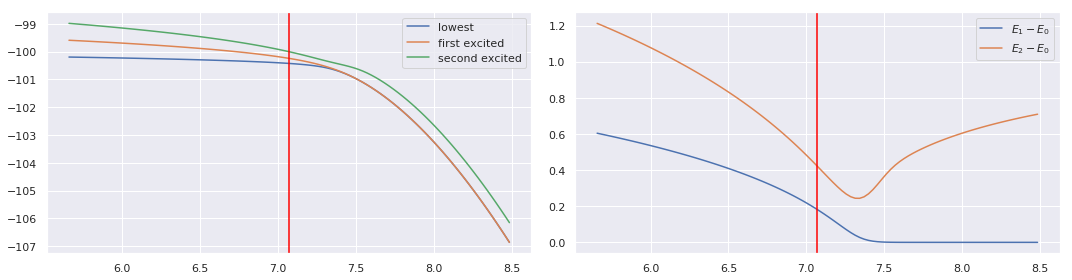

In [147]:
N = 200
Omega = N
omega_0 = 1
lambda_c = np.sqrt(Omega * omega_0) / 2
lambdas = np.linspace(0.8 * lambda_c, 1.2 * lambda_c, 100)
# compute lowest eigvals for each value of interaction parameter
energies = np.asarray([QRM_full(N, Omega, omega_0, lambda_).eigenenergies(eigvals=3) for lambda_ in lambdas])
# ---- plot results
_, axs = plt.subplots(1, 2, figsize=(15, 4))
# leftmost plot
axs[0].plot(lambdas, energies[:, 0], label='lowest')
axs[0].plot(lambdas, energies[:, 1], label='first excited')
axs[0].plot(lambdas, energies[:, 2], label='second excited')
axs[0].axvline(x=lambda_c, c='red')
axs[0].legend()
# rightmost plot
axs[1].plot(lambdas, energies[:, 1] - energies[:, 0], label='$E_1 - E_0$')
axs[1].plot(lambdas, energies[:, 2] - energies[:, 0], label='$E_2 - E_0$')
axs[1].axvline(x=lambda_c, c='red')
axs[1].legend()
plt.tight_layout()

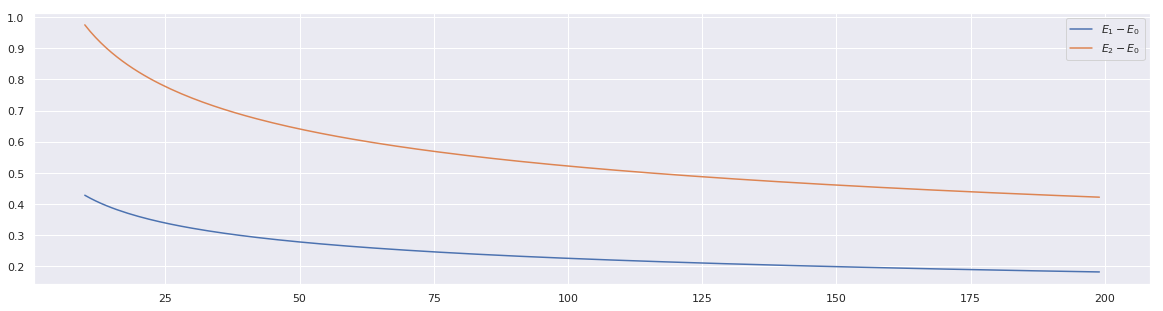

In [149]:
def QRM_first_critical_eigvals(N, Omega, omega_0, num_eigvals=3):
    # set constant coefficients
    lambda_c = np.sqrt(Omega * omega_0) / 2. # critical coefficient
    # set time-independent component of the Hamiltonian
    return QRM_full(N=N, Omega=N, omega_0=omega_0, lambda_=lambda_c).eigenenergies(eigvals=num_eigvals)

N_vals = np.arange(10, 200)
eigvals = np.asarray([QRM_first_critical_eigvals(N, N, 1) for N in N_vals])

plt.figure(figsize=(20, 5))
plt.plot(N_vals, eigvals[:, 1] - eigvals[:, 0], label='$E_1 - E_0$')
plt.plot(N_vals, eigvals[:, 2] - eigvals[:, 0], label='$E_2 - E_0$')
plt.legend();

Crossing the critical point, the QPT can be witnessed using some properties of the ground state, such as $\langle\sigma_z\rangle+1$, whose value goes like $\lvert\lambda-\lambda_c\rvert^\gamma$ in the superradiant phase:

100% (50 of 50) |########################| Elapsed Time: 0:00:26 Time:  0:00:26


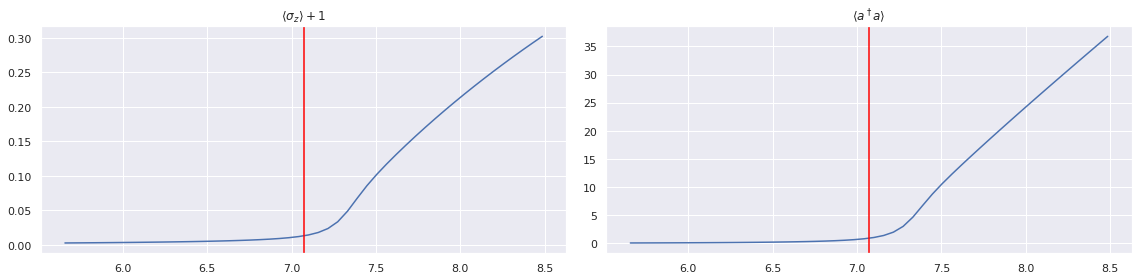

In [382]:
Omega = N = 200
omega_0 = 1
lambda_c = np.sqrt(Omega * omega_0) / 2
# which interaction values to test
lambdas = np.linspace(0.8 * lambda_c, 1.2 * lambda_c, 50)
# compute expval of Z+1
sigmaz_op = qutip.tensor(qutip.qeye(N), qutip.sigmaz() + qutip.qeye(2))
N_op = qutip.tensor(qutip.create(N) * qutip.destroy(N), qutip.qeye(2))
# make expectation values
expvals_sz = np.zeros_like(lambdas)
expvals_N = np.zeros_like(lambdas)
bar = progressbar.ProgressBar()
for idx, lambda_ in enumerate(bar(lambdas)):
    ground_state = QRM_full(N, Omega, omega_0, lambda_).eigenstates(eigvals=1)[1][0]
    expvals_sz[idx] = qutip.expect(sigmaz_op, ground_state)
    expvals_N[idx] = qutip.expect(N_op, ground_state)
# plot results
_, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].plot(lambdas, expvals_sz);
axs[0].set_title(r'$\langle\sigma_z\rangle+1$')
axs[0].axvline(x=lambda_c, c='red');
axs[1].plot(lambdas, expvals_N)
axs[1].set_title(r'$\langle a^\dagger a\rangle$')
axs[1].axvline(x=lambda_c, c='red')
plt.tight_layout();

Interestingly, the fidelity between the ground state of the noninteracting Hamiltonian and that of $H(\lambda)$ (with $\lambda$ interaction parameter) basically jumps at the critical point from $1$ to $0$:

100% (50 of 50) |########################| Elapsed Time: 0:00:19 Time:  0:00:19
100% (50 of 50) |########################| Elapsed Time: 0:00:18 Time:  0:00:18


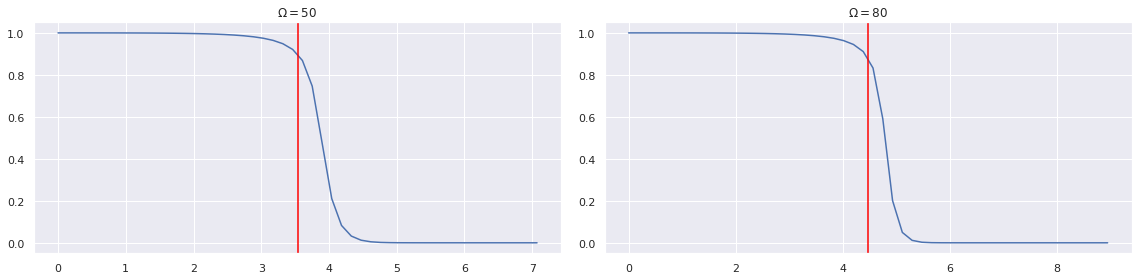

In [397]:
def fidelity_between_ground_states(N, Omega, omega_0, lambda_):
    return qutip.fidelity(
        ground_state(QRM_full(N, Omega, omega_0, lambda_=lambda_)),
        ground_state(QRM_full(N, Omega, omega_0, lambda_=0))
    )
def _():
    N = 100
    omega_0 = 1
    Omega = 50
    lambda_c = np.sqrt(Omega * omega_0) / 2
    lambdas = np.linspace(0, 2 * lambda_c, 50)
    bar = progressbar.ProgressBar()
    ys_1 = [fidelity_between_ground_states(N, Omega, omega_0, lambda_) for lambda_ in bar(lambdas)]
    _, axs = plt.subplots(1, 2, figsize=(16, 4))
    axs[0].plot(lambdas, ys_1)
    axs[0].axvline(x=lambda_c, color='red')
    axs[0].set_title(r'$\Omega={}$'.format(Omega))
    # second plot
    Omega = 80
    lambda_c = np.sqrt(Omega * omega_0) / 2
    lambdas = np.linspace(0, 2 * lambda_c, 50)
    bar = progressbar.ProgressBar()
    ys_2 = [fidelity_between_ground_states(N, Omega, omega_0, lambda_) for lambda_ in bar(lambdas)]
    axs[1].plot(lambdas, ys_2)
    axs[1].axvline(x=lambda_c, color='red')
    axs[1].set_title(r'$\Omega={}$'.format(Omega))
    plt.tight_layout()
_();

# Adiabatic evolution experiments

$$\mathcal H = \frac{\Omega}{2}\sigma_z + \omega_0 \,a^\dagger a - \lambda \sigma_x(a+a^\dagger).$$

100% (39 of 39) |########################| Elapsed Time: 0:00:19 Time:  0:00:19


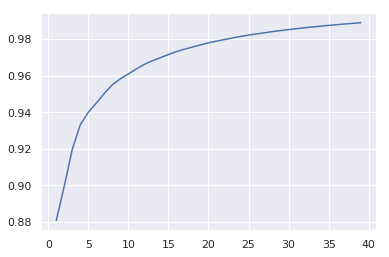

In [205]:
# set where to truncate Fock state
N = 100
# set constant coefficients
Omega = N
omega_0 = 1.
lambda_c = np.sqrt(Omega * omega_0) / 2. # critical coefficient
# set time-independent component of the Hamiltonian
H0 = QRM_free_part(N, Omega, omega_0)
H1 = QRM_interaction_term(N)
# set initial and target states
psi_initial = H0.eigenstates(eigvals=1)[1][0]
psi_target = (H0 + lambda_c * H1).eigenstates(eigvals=1)[1][0]
# define time-dependent coefficient
bar = progressbar.ProgressBar()
def adiabatic_evolution(tf):
    times_list = np.linspace(0, tf, 40)
    def adiabatically_evolving_lambda(t, args):
        return t / tf * lambda_c
    # final Hamiltonian
    H = [H0, [H1, adiabatically_evolving_lambda]]
    # evolve
    output = qutip.mesolve(H, psi_initial, tlist=times_list)
    fid = qutip.fidelity(psi_target, output.states[-1])
    return fid
times = np.arange(1, 40)
fids = [adiabatic_evolution(tf) for tf in bar(times)]
plt.plot(times, fids);

N=100:		fidelity=0.9608926368086417
N=200:		fidelity=0.9391091660615882
N=300:		fidelity=0.9240524659944421
N=400:		fidelity=0.9124560636413692
N=500:		fidelity=0.9029854709934537
N=600:		fidelity=0.8949757279340196
N=700:		fidelity=0.8880304605087055
N=800:		fidelity=0.8818895538231291
N=900:		fidelity=0.8763858260075212


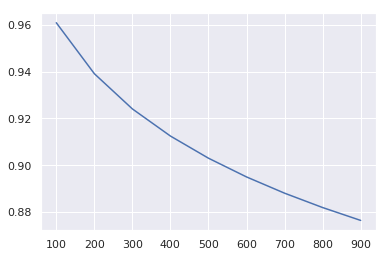

In [253]:
# set where to truncate Fock state
N_values = np.arange(100, 1000, 100)
tf = 10.
# set constant coefficients
fids = []
for N in N_values:
    Omega = N
    omega_0 = 1.
    lambda_c = np.sqrt(Omega * omega_0) / 2. # critical coefficient
    H0 = QRM_free_part(N, Omega, omega_0)
    H1 = QRM_interaction_term(N)
    # set initial and target states
    psi_initial = H0.eigenstates(eigvals=1)[1][0]
    psi_target = (H0 + lambda_c * H1).eigenstates(eigvals=1)[1][0]
    # define time-dependent coefficient
    def adiabatic_evolution():
        times_list = np.linspace(0, tf, 100)
        def adiabatically_evolving_lambda(t, args):
            return t / tf * lambda_c
        # final Hamiltonian
        H = [H0, [H1, adiabatically_evolving_lambda]]
        # evolve
        output = qutip.mesolve(H, psi_initial, tlist=times_list)
        fid = qutip.fidelity(psi_target, output.states[-1])
        return fid
    fids.append(adiabatic_evolution())
    print('N={}:\t\tfidelity={}'.format(N,fids[-1]))
plt.figure()
plt.plot(N_values, fids)

# Failed attempts at OC with qutip

In [206]:
logger = logging.get_logger()
log_level = logging.INFO

N = 100
Omega = N
omega_0 = 1.
lambda_c = np.sqrt(Omega * omega_0) / 2. # critical coefficient
H0 = QRM_free_part(N, Omega, omega_0)
H1 = QRM_interaction_term(N)
psi_initial = H0.eigenstates(eigvals=1)[1][0]
psi_target = (H0 + lambda_c * H1).eigenstates(eigvals=1)[1][0]

n_ts = 100  # Number of time slots
evo_time = 18  # Time allowed for the evolution
fid_err_targ = 1e-3  # Fidelity error target
max_iter = 500  # Maximum iterations for the optisation algorithm
max_wall_time = 120  # Maximum (elapsed) time allowed in seconds
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'DEF'
# Set to None to suppress output files
f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)

# run the optimization
result = cpo.opt_pulse_crab_unitary(
    H0, [H1],
    psi_initial, psi_target, n_ts, evo_time, 
    fid_err_targ=fid_err_targ,
    max_iter=max_iter, max_wall_time=max_wall_time,
    init_coeff_scaling=5.0, num_coeffs=5,
    method_params={'xtol':1e-3},
    guess_pulse_type=None, guess_pulse_action='modulate',
    out_file_ext=f_ext,
    log_level=log_level, gen_stats=True
)

INFO:qutip.control.dynamics:Setting memory optimisations for level 0
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>
INFO:qutip.control.dynamics:phased dynamics generator caching True
INFO:qutip.control.dynamics:propagator gradient caching True
INFO:qutip.control.dynamics:eigenvector adjoint caching True
INFO:qutip.control.dynamics:use sparse eigen decomp False
INFO:qutip.control.pulseoptim:System configuration:
Drift Hamiltonian:
Quantum object: dims = [[100, 2], [100, 2]], shape = (200, 200), type = oper, isherm = True
Qobj data =
[[ 50.   0.   0. ...   0.   0.   0.]
 [  0. -50.   0. ...   0.   0.   0.]
 [  0.   0.  51. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...  48.   0.   0.]
 [  0.   0.   0. ...   0. 149.   0.]
 [  0.   0.   0. ...   0.   0.  49.]]
Control 1 Hamiltonian:
Quantum object: dims = [[100, 2], [100, 2]], shape = (200, 200), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.         ...  0.          0.
  

In [207]:
result.stats.report()
# print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(
        datetime.timedelta(seconds=result.wall_time)))


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:02:03.593199
Wall time computing Hamiltonians: 0:00:01.433913 (1.16%)
Wall time computing propagators: 0:02:01.535300 (98.33%)
Wall time computing forward propagation: 0:00:00.262323 (0.21%)
Wall time computing onward propagation: 0:00:00.259304 (0.21%)
Wall time computing gradient: 0:00:00 (0.00%)

**** Iterations and function calls ****
Number of iterations: 5
Number of fidelity function calls: 22
Number of times fidelity is computed: 22
Number of gradient function calls: 0
Number of times gradients are computed: 0
Number of times timeslot evolution is recomputed: 22

**** Control amplitudes ****
Number of control amplitude updates: 21
Mean number of updates per iteration: 4.2
Number of timeslot values changed: 2099
Mean number of timeslot changes per update: 99.95238095238095
Number of amplitude values changed: 2099
Mean number of 

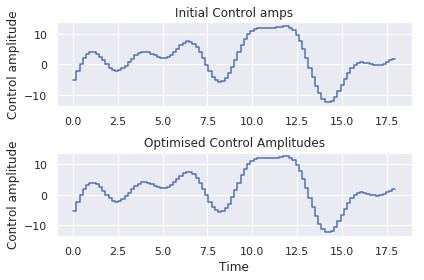

In [208]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial Control amps")
ax1.set_ylabel("Control amplitude")
ax1.step(result.time, 
         np.hstack((result.initial_amps[:, 0], result.initial_amps[-1, 0])), 
         where='post')

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Amplitudes")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
ax2.step(result.time, 
         np.hstack((result.final_amps[:, 0], result.final_amps[-1, 0])), 
         where='post')
plt.tight_layout()
plt.show()

# Manually implemented CRAB OC

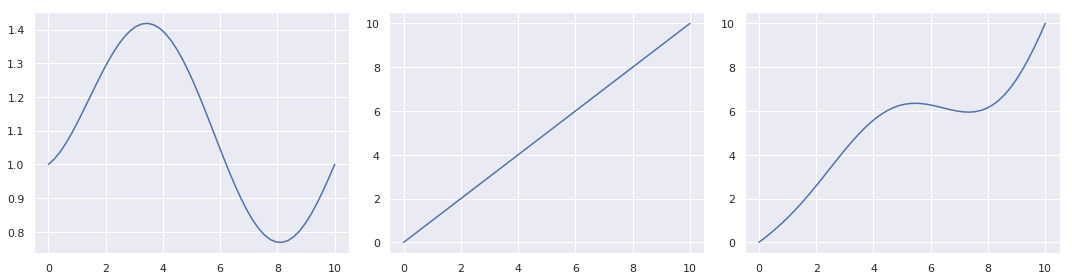

In [16]:
tf = 10
fun = rabi_model._make_CRAB_pulse_fun(0.1 * np.random.randn(2), 0.1 * np.random.randn(2), np.random.randn(2), tf)
linear_ramp = lambda t: rabi_model.linear_ramp(t, t0=0, t1=tf, y0=0, y1=10)


times = np.linspace(0, tf, 50)
ys = np.asarray([fun(t) for t in times])
linear_ys = np.asarray([linear_ramp(t) for t in times])

_, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(times, ys);
axs[1].plot(times, linear_ys)
axs[2].plot(times, ys * linear_ys)
plt.tight_layout()

In [24]:
rabi_model.run_QRM_CRAB_optimization(N=100, tf=.5).fun

Random frequencies: [0.09865408 0.4535566 ]


0.12470669173839855

For each different total evolution time run CRAB optimization with two frequencies (4 parameters in total)

In [124]:
def optimize_CRAB_different_times(times):
    results = np.zeros(shape=[len(times), 8])
    bar = progressbar.ProgressBar()
    for idx, time in enumerate(bar(times)):
        result = run_QRM_CRAB_optimisation(N=100, Omega=100, omega_0=1, tf=time, stfo=True)
        results[idx] = [time, 1 - result.fun, *result.data['nuk'], *result.x]
    results = pd.DataFrame(results, columns=['tf', 'fid', 'nu1', 'nu2', 'par1', 'par2', 'par3', 'par4'])
    return results
results = optimize_CRAB_different_times(times=np.linspace(0.1, 4, 100))
results.to_csv('rabi_Omega100_crab_2frequencies.csv')

100% (100 of 100) |######################| Elapsed Time: 1:07:31 Time:  1:07:31


Like above but with three frequencies, 6 parameters

In [ ]:
def optimize_CRAB_different_times(times):
    results = np.zeros(shape=[len(times), 11])
    bar = progressbar.ProgressBar()
    for idx, time in enumerate(bar(times)):
        result = rabi_model.run_QRM_CRAB_optimization(N=100, Omega=100, omega_0=1, tf=time, stfo=True,
                                           initial_pars=np.zeros(6))
        results[idx] = [time, 1 - result.fun, *result.data['nuk'], *result.x]
    results = pd.DataFrame(
        results,
        columns=['tf', 'fid', 'nu1', 'nu2', 'nu3', 'par1', 'par2', 'par3', 'par4', 'par5', 'par6']
    )
    return results
results = optimize_CRAB_different_times(times=np.linspace(0.1, 4, 100))
results.to_csv('rabi_Omega100_crab_3frequencies.csv')

 19% (19 of 100) |####                   | Elapsed Time: 0:07:04 ETA:   1:50:39

In [70]:
def run_QRM_CRAB_optimisation_and_show_results(
        N, Omega, omega_0, tf, nuk=None,
        save_to_file=True
    ):
    """Run optimization and produce plots with results."""
    lambda_c = np.sqrt(Omega * omega_0) / 2.

    if nuk is None:
        n_crab_freqs = 2  # the number of different frequencies
        nuk = np.random.rand(n_crab_freqs)
    else:
        n_crab_freqs = len(nuk)
        nuk = np.asarray(nuk)

    results = run_QRM_CRAB_optimisation(
        N, Omega, omega_0, tf, nuk,
        initial_pars=np.zeros(n_crab_freqs * 2)
    )
    
    # save results to file
    if save_to_file:
        timestr = time.strftime("%m%d-%H%M")
        filename = 'N{}_Omega{}_tf{}_{}'.format(N, Omega, tf, timestr)
        idx = 0
        while True:
            if os.path.isfile(filename + '.pickle'):
                idx += 1
                filename += '({})'.format(idx)
            else:
                break
        filename += '.pickle'
        print('Saving results to {}'.format(filename))
        with open(filename, 'wb') as f:
            pickle.dump(results, f)

    # recompute final ramp
    final_ramp = make_final_ramp_fun(*results.x.reshape((2, n_crab_freqs)), nuk, tf, lambda_c)
    # resimulate evolution
    H0 = results.data['H0']
    H1 = results.data['H1']
    H = [H0, [H1, final_ramp]]
    psi_initial = results.data['psi_initial']
    psi_target = results.data['psi_target']

    # plot resuts
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    times = np.linspace(0, tf, 100)
    ys = [final_ramp(t) for t in times]
    axs[0].set_title('Final ramp shape')
    axs[0].plot(times, ys);

    times = np.linspace(0, tf, 50)
    output_state = qutip.mesolve(H, psi_initial, tlist=times)
    fids_target = [qutip.fidelity(psi_target, state) for state in output_state.states]
    fids_initial = [qutip.fidelity(psi_initial, state) for state in output_state.states]
    print('Final fidelity: {}'.format(fids_target[-1]))
    # compute slope of final run for the gold
    slope_ref_times = (times[np.argmin(fids_target)], times[np.argmax(fids_target)])
    slope = np.arccos(np.max(fids_target)) - np.arccos(np.min(fids_target))
    slope /= slope_ref_times[1] - slope_ref_times[0]
    # plot fidelity target vs current state
    axs[1].set_title('Target vs current state. Slope={}'.format(slope))
    axs[1].plot(times, fids_target)
    # plot fidelity initial vs current state
    axs2 = axs[1].twinx()
    axs2.set_ylabel('initial vs current', color='r')
    axs2.tick_params('y', colors='r')
    axs2.plot(times, fids_initial, color='r')

    plt.tight_layout();
    return results

In [18]:
def QSL_estimate(N, Omega, omega_0):
    lambda_c = np.sqrt(Omega * omega_0) / 2
    # compute bures angle
    psi_initial = ground_state(QRM_free_term(N, Omega, omega_0))
    psi_target = ground_state(QRM_full(N, Omega, omega_0, lambda_c))
    angle = qutip.bures_angle(psi_initial, psi_target)
    # compute gap
    lowest_eigvals = QRM_full(N, Omega, omega_0, lambda_c).eigenenergies(eigvals=3)
    gap = lowest_eigvals[2] - lowest_eigvals[0]
    # compute QSL
    return angle / gap

def results_to_ramp_function(results):
    nuk = results.data['nuk']
    tf = results.data['tf']
    lambda_c = results.data['lambda_c']
    num_pars = len(nuk)
    return make_final_ramp_fun(*results.x.reshape((2, num_pars)), nuk, tf, lambda_c)

def results_to_H(results, N=None):
    if N is None:
        N = results.data['N']
    Omega = results.data['Omega']
    omega_0 = results.data['omega_0']
    H0 = QRM_free_term(N, Omega, omega_0)
    H1 = QRM_interaction_term(N)
    ramp = results_to_ramp_function(results)
    return [H0, [H1, ramp]]

def results_resimulate_evolution(results, N=None):
    if N is None:
        N = results.data['N']
    Omega = results.data['Omega']
    omega_0 = results.data['omega_0']
    lambda_c = results.data['lambda_c']
    H0 = QRM_free_term(N, Omega, omega_0)
    H1 = QRM_interaction_term(N)
    ramp = results_to_ramp_function(results)
    psi_initial = ground_state(H0)
    psi_target = ground_state(H0 + lambda_c * H1)
    psi_output = qutip.mesolve(
        H=[H0, [H1, ramp]],
        rho0=psi_initial,
        tlist=np.linspace(0, results.data['tf'], 100)
    ).states[-1]
    return qutip.fidelity(psi_output, psi_target)

# results_resimulate_evolution(results, N=100)

QSL_estimate(100, 100, 1)

0.9817649940060547

What is $\Delta H$ at the critical point?

In [68]:
def _():
    Es = QRM_full(100, 100, 1, 5).eigenenergies()
    return np.sqrt(np.mean(Es**2) - np.mean(Es)**2)
_()

76.21187571500914

N=100		Omega=100		tf=0.8		fid=0.8977613354016922
N=100		Omega=100		tf=0.8		fid=0.899445362011717
N=100		Omega=100		tf=0.8		fid=0.8929265273123387
N=100		Omega=100		tf=0.9		fid=0.9103549481057538
N=100		Omega=100		tf=1.1		fid=0.9195141625657096
N=100		Omega=100		tf=1.2		fid=0.9160599763304308
N=100		Omega=100		tf=1.3		fid=0.9462625645898265
N=100		Omega=100		tf=1.4		fid=0.9534970255268496
N=100		Omega=100		tf=1.5		fid=0.932709375626779
N=100		Omega=100		tf=1.5		fid=0.9653796572171343
N=100		Omega=100		tf=1.5		fid=0.9626420763343334
N=100		Omega=100		tf=1.5		fid=0.9502187215431726
N=100		Omega=100		tf=1.5		fid=0.9655717511266231
N=100		Omega=100		tf=1.7		fid=0.9848275135358577
N=100		Omega=100		tf=1.8		fid=0.9890449140565354
N=100		Omega=100		tf=1.9		fid=0.9997928961522405
N=100		Omega=100		tf=1		fid=0.9115621676240845
N=100		Omega=100		tf=2.0		fid=0.9989947396335838
N=100		Omega=100		tf=2.0		fid=0.9781346710762178
N=100		Omega=100		tf=2.0		fid=0.9729788394616654
N=100		Omega=100		tf=2.0

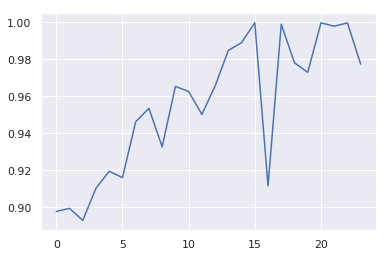

In [501]:
import glob
files = sorted(glob.glob('*.pickle'))
fids = []
for file in files:
    with open(file, 'rb') as f:
        data = pickle.load(f)
    fid = results_resimulate_evolution(data)
    fids.append(fid)
    print('N={}\t\tOmega={}\t\ttf={}\t\tfid={}'.format(
        data.data['N'], data.data['Omega'], data.data['tf'], fid
    ))
plt.figure()
plt.plot(fids);

## CRAB optimisation tests

Saving results to N100_Omega100_tf0.8_0828-1457.pickle
Final fidelity: 0.8973153723462358


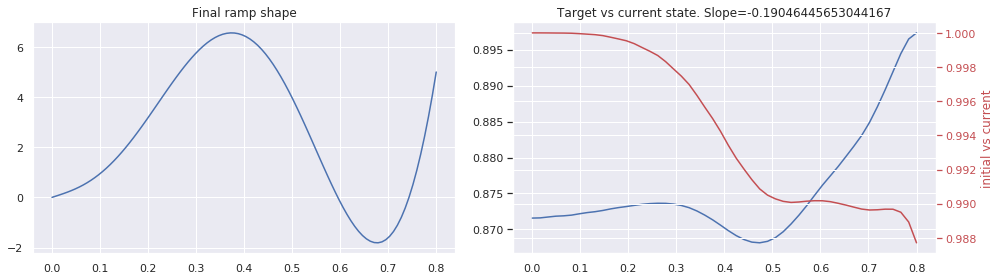

In [71]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=0.8)

Saving results to N100_Omega100_tf0.8_0828-1458.pickle
Final fidelity: 0.8995202770251817


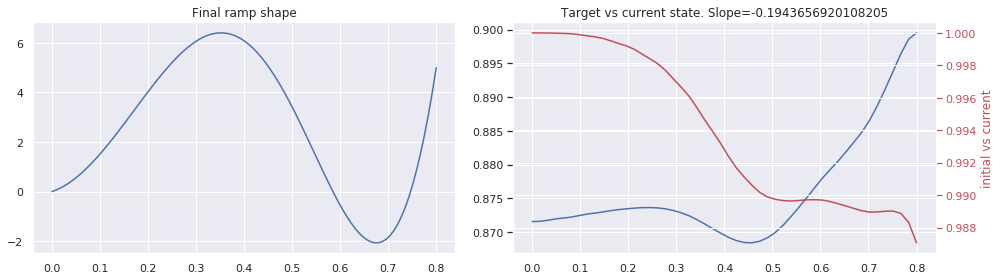

In [72]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=0.8)

Saving results to N100_Omega100_tf0.8_0828-1458(1).pickle
Final fidelity: 0.8994048539243767


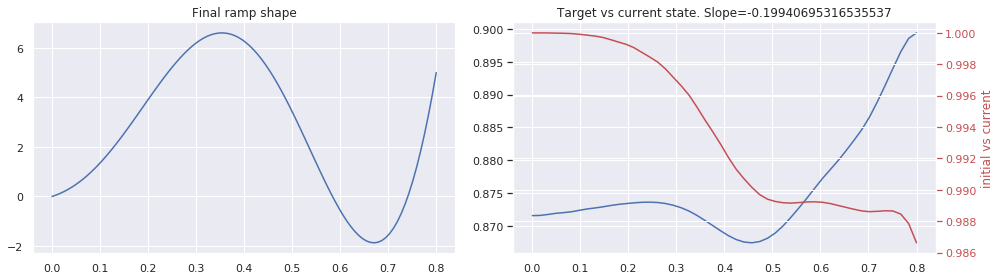

In [73]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=0.8)

Saving results to N100_Omega100_tf0.9_0828-1459.pickle
Final fidelity: 0.9003770392947992


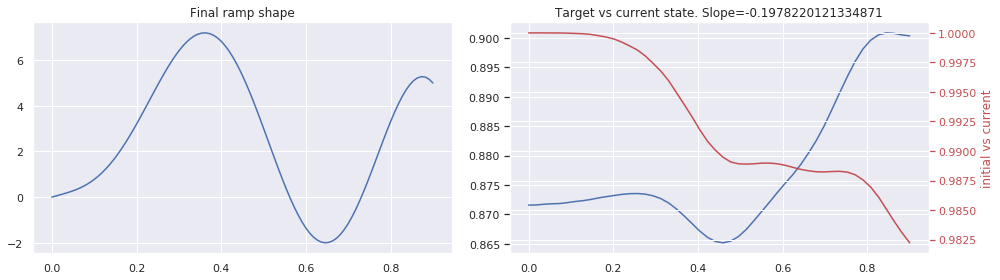

In [74]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=0.9)

Saving results to N100_Omega100_tf1_0828-1500.pickle
Final fidelity: 0.9083414527827656


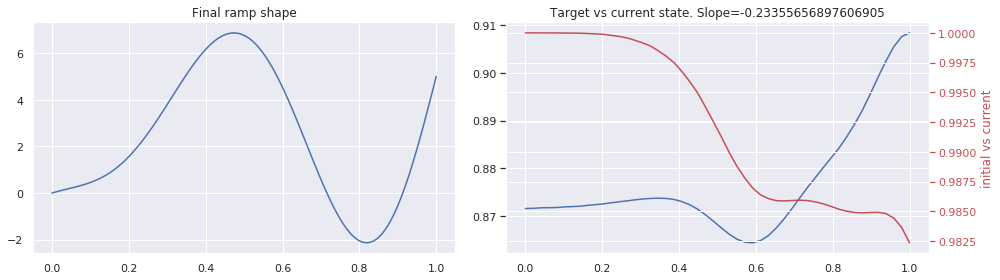

In [75]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=1)

Saving results to N100_Omega100_tf1.1_0828-1500.pickle
Final fidelity: 0.8977628549742088


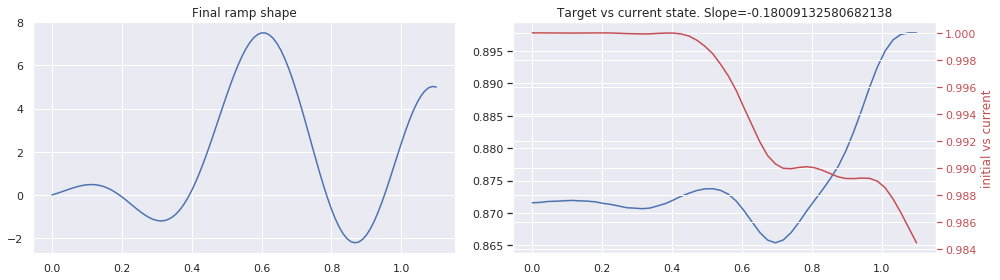

In [76]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=1.1)

Saving results to N100_Omega100_tf1.2_0828-1501.pickle
Final fidelity: 0.9234541438608169


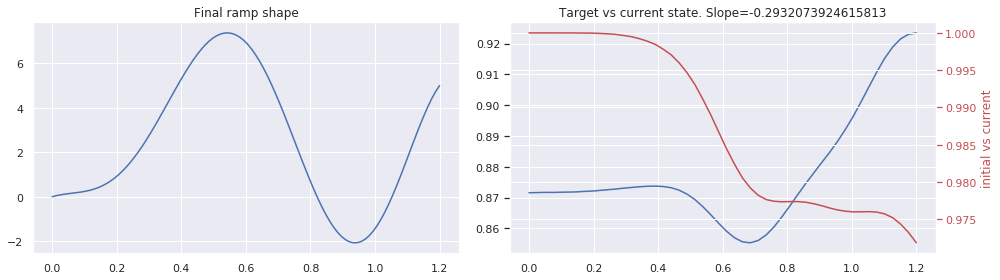

In [77]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=1.2)

Saving results to N100_Omega100_tf1.3_0828-1502.pickle
Final fidelity: 0.9063976722462459


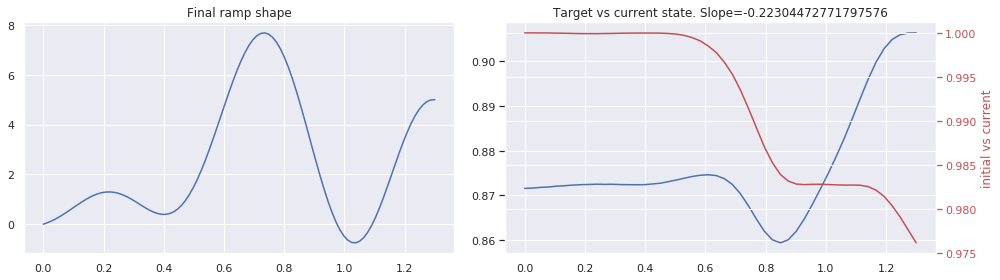

In [78]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=1.3)

Saving results to N100_Omega100_tf1.4_0828-1503.pickle
Final fidelity: 0.9561516464918991


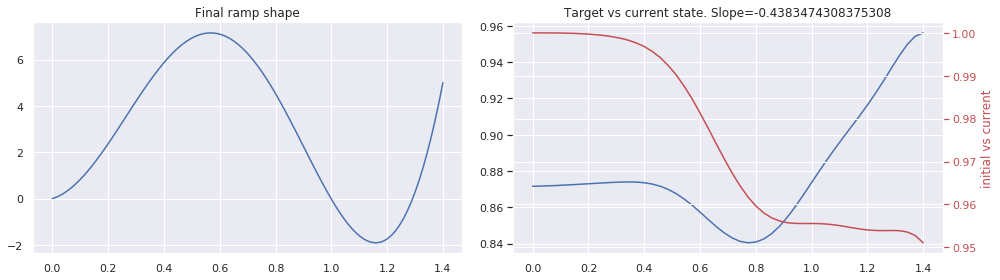

In [79]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=1.4)

Saving results to N100_Omega100_tf1.5_0828-1504.pickle
Final fidelity: 0.9352221153705658


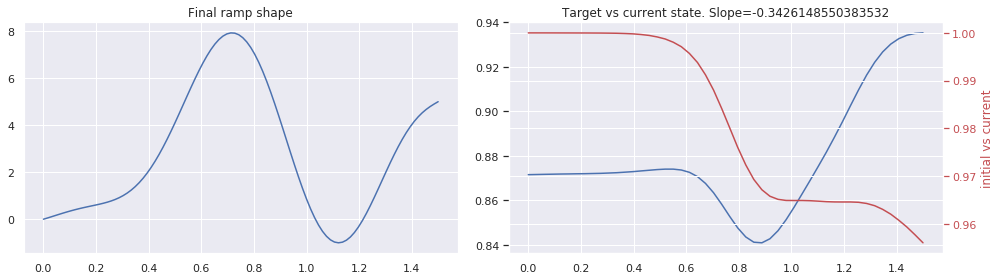

In [80]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=1.5)

Saving results to N100_Omega100_tf1.5_0828-1505.pickle
Final fidelity: 0.957656152184986


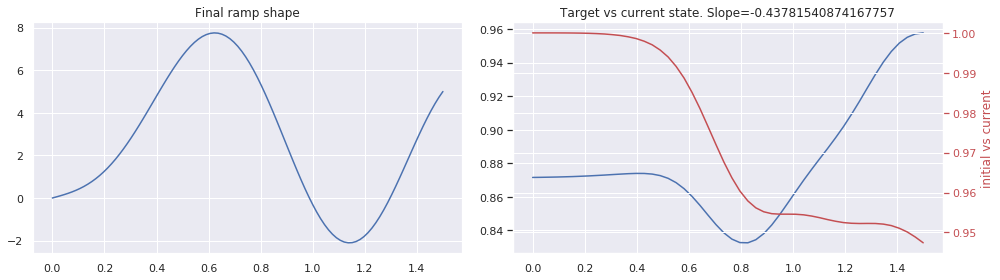

In [81]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=1.5,
                                                     nuk=np.random.rand(3) - 0.5)

Saving results to N100_Omega100_tf1.6_0828-1506.pickle
Final fidelity: 0.9493563647822534


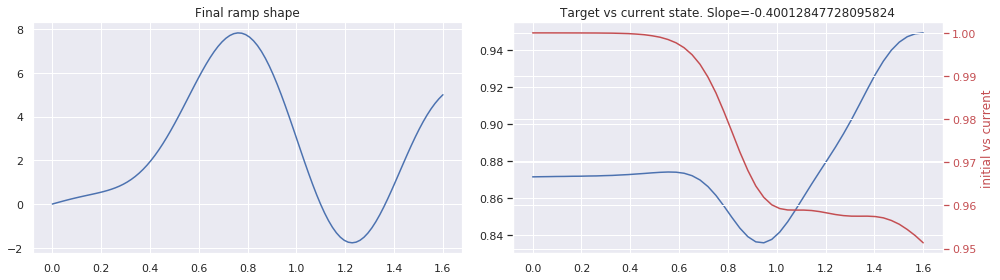

In [82]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=1.6)

Saving results to N100_Omega100_tf1.7_0828-1507.pickle
Final fidelity: 0.9984500352035375


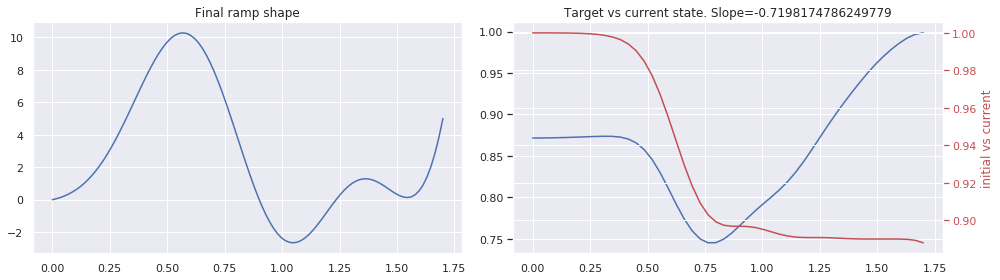

In [83]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=1.7)

Saving results to N100_Omega100_tf1.8_0828-1507.pickle
Final fidelity: 0.9723091692820689


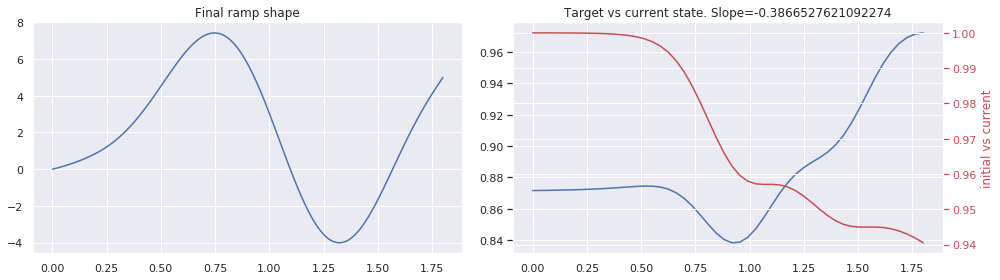

In [84]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=1.8)

Saving results to N100_Omega100_tf1.9_0828-1508.pickle
Final fidelity: 0.9809326352898644


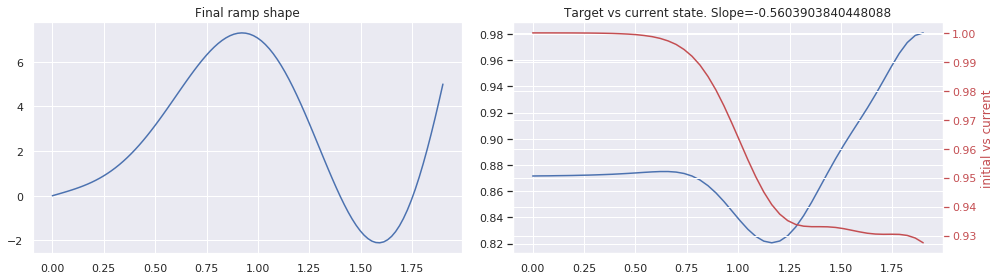

In [85]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=1.9)

Saving results to N100_Omega100_tf2.0_0828-1509.pickle
Final fidelity: 0.9824189385885017


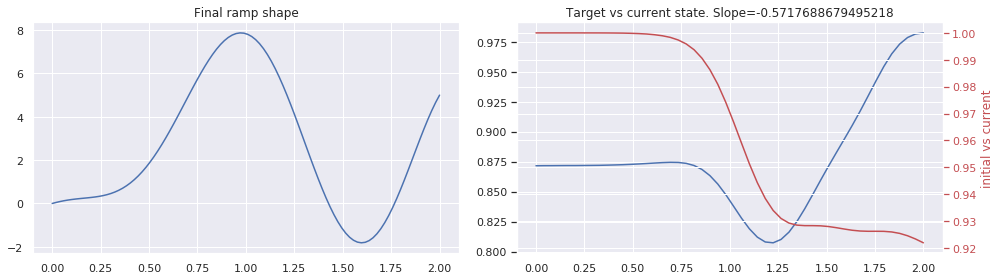

In [86]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=2.0)

Saving results to N100_Omega100_tf2.0_0828-1510.pickle
Final fidelity: 0.9900247591643583


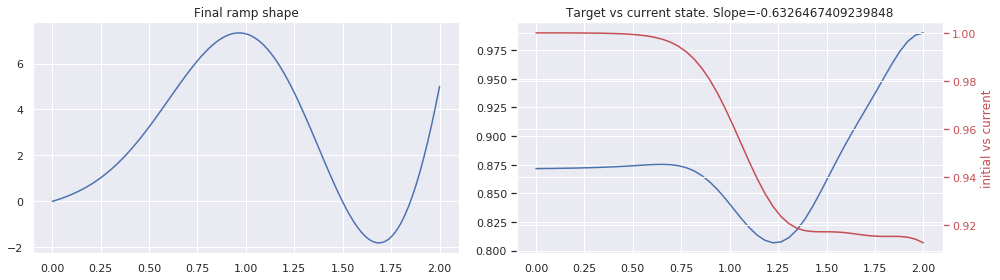

In [87]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=2.0)

Saving results to N100_Omega100_tf2.0_0828-1512.pickle
Final fidelity: 0.9779627454359046


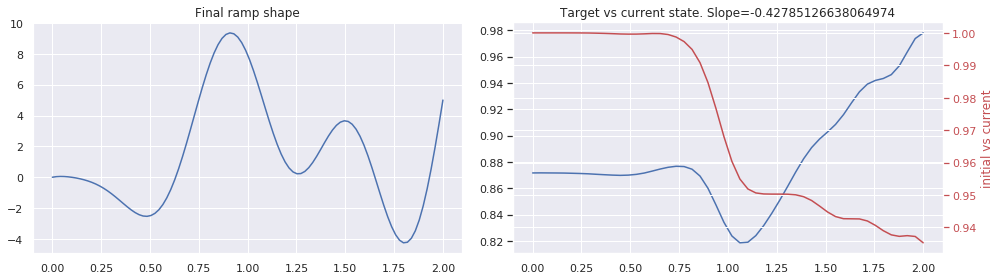

In [88]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=2.0,
                                                     nuk=np.random.rand(3))

Saving results to N100_Omega100_tf2.0_0828-1514.pickle
Final fidelity: 0.9997087878911755


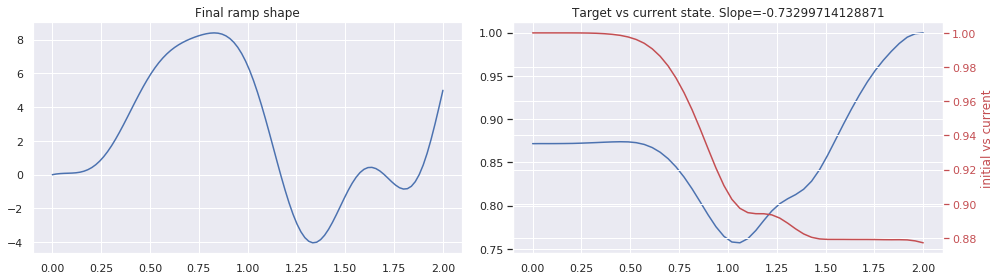

In [89]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=2.0,
                                                     nuk=[1, 1, 1])

Saving results to N100_Omega100_tf2.1_0828-1515.pickle
Final fidelity: 0.9997469112570798


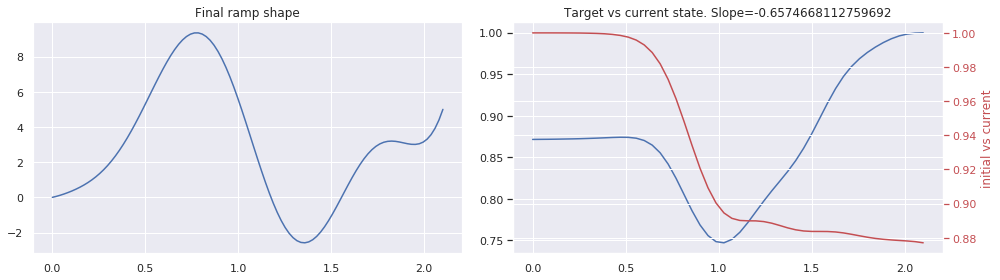

In [90]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=2.1)

Saving results to N100_Omega100_tf6.0_0828-1516.pickle
Final fidelity: 0.9998366009923125


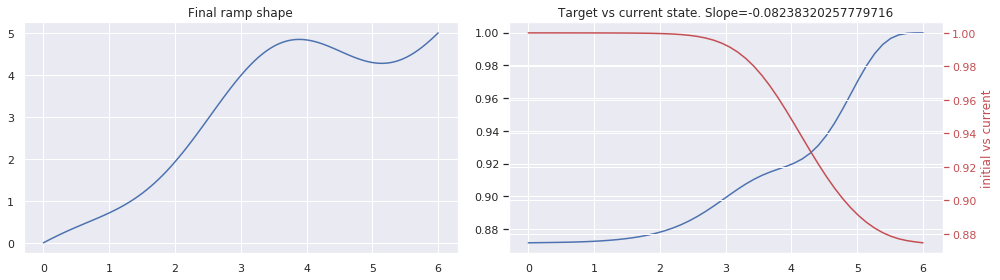

In [91]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=6.0,
                                                     nuk=np.random.rand(4) - 0.5)

Saving results to N100_Omega100_tf2.0_0828-1518.pickle
Final fidelity: 0.9996716830188318


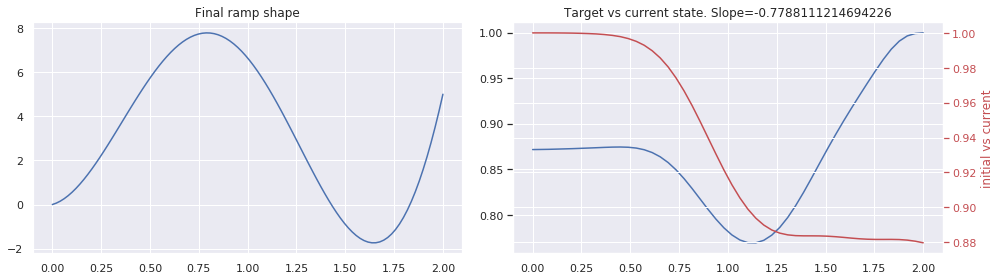

In [92]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=100, omega_0=1, tf=2.0,
                                                     nuk=np.random.rand(3) - 0.5)

Saving results to N100_Omega60_tf2.0_0828-1518.pickle
Final fidelity: 0.9997284965836735


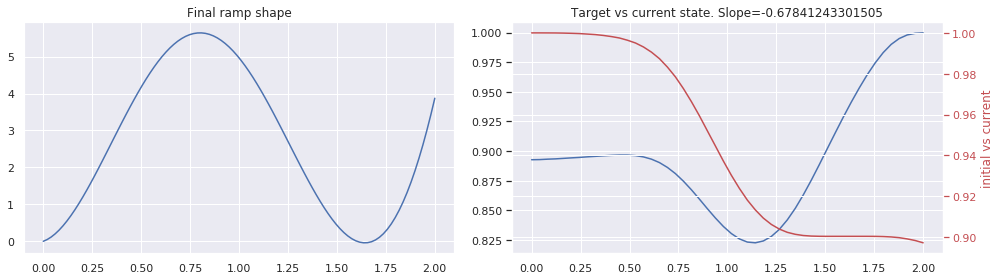

In [93]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=60, omega_0=1, tf=2.0,
                                                     nuk=np.random.rand(2) - 0.5)


## Optimizations with different $\Omega$

Saving results to N100_Omega50_tf2.0_0828-1519.pickle
Final fidelity: 0.9950162577074959


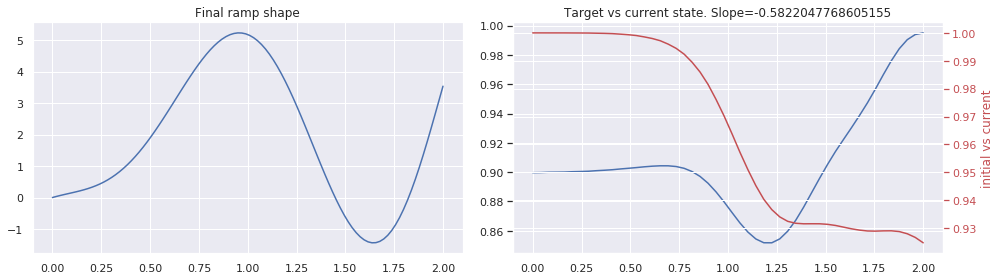

In [94]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=50, omega_0=1, tf=2.0)

Saving results to N100_Omega60_tf2.0_0828-1520.pickle
Final fidelity: 0.9997511802517788


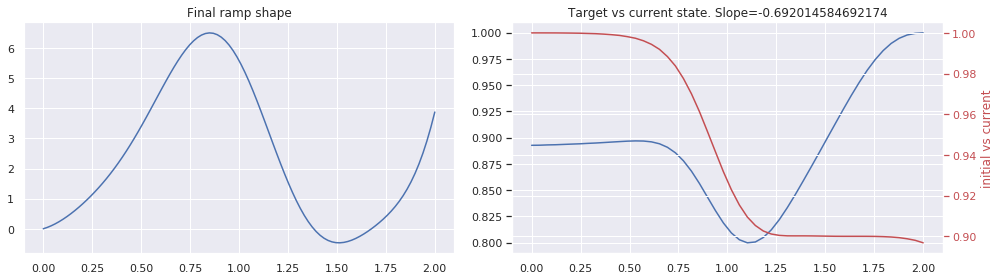

In [95]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=60, omega_0=1, tf=2.0)

Saving results to N100_Omega70_tf2.0_0828-1521.pickle
Final fidelity: 0.9867494029423158


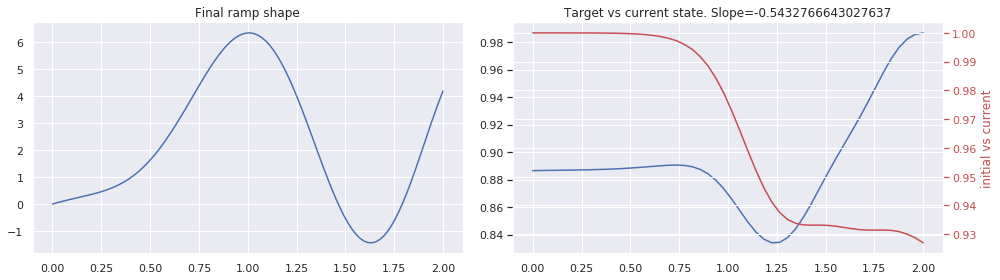

In [96]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=70, omega_0=1, tf=2.0)

Saving results to N100_Omega80_tf2.0_0828-1521.pickle
Final fidelity: 0.9933348202423339


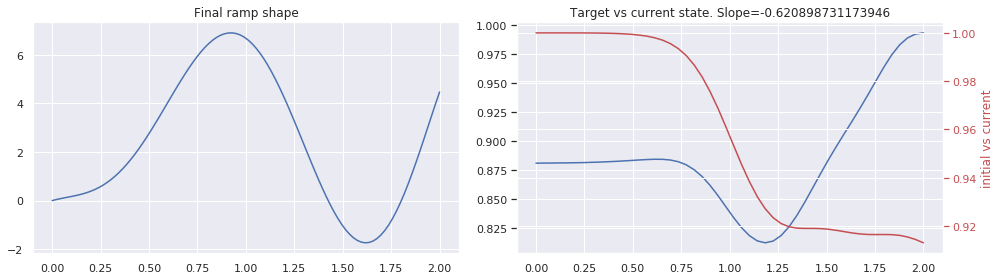

In [97]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=80, omega_0=1, tf=2.0)

Saving results to N100_Omega90_tf2.0_0828-1523.pickle
Final fidelity: 0.9956747584589449


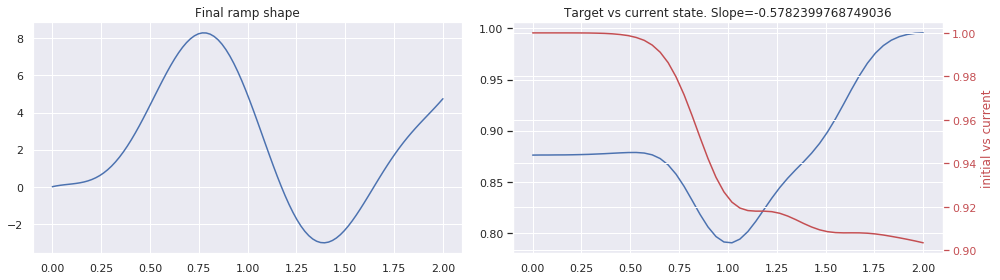

In [98]:
results = run_QRM_CRAB_optimisation_and_show_results(N=100, Omega=90, omega_0=1, tf=2.0)